# MODIS Water XGBOOST Hyperparameter Tuning - Folium

Version: 0.4.0

Date modified: 04.21.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

import optuna

from sklearn.metrics import accuracy_score, roc_curve, auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

sys.path.append('../scripts/')
import notebook_util as nu

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [7]:
FIGURE_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/css/modis/Collection6.1/'

GPU = True
TILE = 'Golden'
MODEL = 'xgboost'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = [] # ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [8]:
colsToDrop

[]

In [9]:
colsToDropTraining

['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

In [10]:
if GPU:
    nu.setup_one_gpu() # Choose the GPU with the lowest memory usage

Picking GPU 0


In [11]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [12]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = sorted([fv for fv in glob.glob(glob_string)])
data_path = data_paths[0]
pprint(data_paths)
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip',
 '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip


In [13]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [14]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [15]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,604200.0,1409.770214,2214.920900,-100.0,147.0,722.0,1418.0,16000.0
sur_refl_b02_1,604200.0,2008.445295,2041.982849,-100.0,136.0,1978.0,2633.0,16000.0
sur_refl_b03_1,604200.0,1137.808304,2234.639041,-100.0,204.0,367.0,695.0,13347.0
sur_refl_b04_1,604200.0,1338.361404,2211.601985,-100.0,283.0,655.0,1061.0,16000.0
sur_refl_b05_1,604200.0,1946.345727,1825.754406,-28672.0,101.0,2310.0,3126.0,14954.0
sur_refl_b06_1,604200.0,1576.709618,1354.326951,-100.0,88.0,1531.0,2653.0,11197.0
sur_refl_b07_1,604200.0,439.674139,4341.278593,-28672.0,46.0,724.0,1748.0,7346.0
ndvi,604200.0,-302.827075,6822.629312,-32727.0,-3446.0,1257.0,4200.0,32679.0
ndwi1,604200.0,-1579.143275,6122.607614,-32679.0,-3185.0,-1056.0,1891.0,32762.0
ndwi2,604200.0,298.048658,7414.053522,-32727.0,-1503.0,1057.0,5340.0,32762.0


In [16]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [17]:
ndviOverTenK = output_interesting_idx(X_train, 'ndvi', 10000)
ndviOverTenK

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
422689,11,-6,59,60,32,46,15,31536,-13000,-23333
80522,5,-17,18,89,-7,62,31,18333,-17555,31251
613549,-29,36,44,90,171,623,595,27321,-8907,-8858
963241,1,-83,252,103,-71,73,33,10243,24928,23200
472983,-3,2,48,64,86,140,87,15536,-9718,-9550
...,...,...,...,...,...,...,...,...,...,...
272725,-16,65,37,33,146,236,174,16530,-5681,-4560
107961,19,-12,103,98,69,13,38,21251,12144,-19230
359280,-4,10,74,111,125,99,18,23333,-8165,-2857
630119,8,-24,156,89,9,17,37,20000,-6965,18613


## XGBOOST

Choose which combination of hyperparameters to train:

- n_estimators: Number of learners for the xgboost to fit.
- booster: Which booster to use
- lamda: L2 regularization rate
- alpha: L1 regularization rate
- subsample: sampling ration for training data
- colsample_bytree: sampling according to each tree
- max_depth: maximum depth of the tree, signifies complexity
- min_child_weight: minimum child weight, the larger the term, the more complex
- gamme: how selective the algorithm is

In [18]:
def objective(trial):
    hyperparameters = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "hist",
        #"gpu_id": 0,
        "n_jobs": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 75, 100, 150, 175, 200, 250, 300, 500]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 30, 50, step=5), 
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight":  trial.suggest_int("min_child_weight", 2, 10), 
        "eta":  trial.suggest_float("eta", 1e-8, 1.0, log=True), 
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True), 
        "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    classifier = xgb.XGBClassifier(**hyperparameters)
    eval_set = [(X_train, y_train), (X_val, y_val)]
    eval_metric = ["error","auc"]
    classifier.fit(X_train, 
                   y_train, 
                   eval_set=eval_set, 
                   eval_metric=eval_metric, 
                   early_stopping_rounds=10, 
                   callbacks=[pruning_callback],
                   verbose=False)
    preds = classifier.predict(X_test)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    print('Confusion matrix')
    # From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('TP: {:9} FN: {:9}'.format(tp, fn))
    print('FP: {:9} TN: {:9}'.format(fp, tn))
    print('MCC: {}'.format(mcc))
    print('Precision: {}'.format(precision))
    print('F1 score: {}'.format(f1))
    return f1

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 10, 30, step=5),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[10, 15, 20, 25, 30]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [19]:
search_space={
    "n_estimators":[500],
    "max_depth":[30, 35, 40, 45, 50, 75],
}

If you want to only exhaust the search space above, set `GRID_SEARCH = True`.

In [20]:
GRID_SEARCH = False

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [21]:
optuna.logging.set_verbosity(optuna.logging.INFO)

if GRID_SEARCH:
    study = optuna.create_study(study_name='XGBOOST Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(search_space))
    
else:
    study = optuna.create_study(study_name='XGBOOST Tuning',
                                direction='maximize')

study.optimize(objective, n_trials=10, timeout=10*60)

[I 2023-02-16 11:49:34,632] A new study created in memory with name: XGBOOST Tuning
[I 2023-02-16 11:50:21,957] Trial 0 finished with value: 0.977916522141288 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.28496526548607803, 'alpha': 0.34131542003805226, 'subsample': 0.20584517186908002, 'colsample_bytree': 0.8695763223614645, 'max_depth': 50, 'min_child_weight': 3, 'eta': 0.03276461912090576, 'gamma': 0.013056567804844385, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.977916522141288.


Confusion matrix
TP:     84580 FN:      2225
FP:      1595 TN:    113000
MCC: 0.9613147896394405
Precision: 0.9814911517261387
F1 score: 0.977916522141288


[I 2023-02-16 11:50:38,895] Trial 1 finished with value: 0.9734672133046116 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 1.941842780444235e-05, 'alpha': 0.0030023085372214778, 'subsample': 0.6942796261413162, 'colsample_bytree': 0.5508318640655274, 'max_depth': 40, 'min_child_weight': 10, 'eta': 0.00020724677463357307, 'gamma': 0.22797492292871732, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.977916522141288.


Confusion matrix
TP:     84055 FN:      2750
FP:      1832 TN:    112763
MCC: 0.9535970933383254
Precision: 0.9786696473273021
F1 score: 0.9734672133046116


[I 2023-02-16 11:51:20,596] Trial 2 finished with value: 0.9710634445295633 and parameters: {'n_estimators': 150, 'booster': 'gbtree', 'lambda': 5.8899378107022385e-06, 'alpha': 1.4642759851297656e-05, 'subsample': 0.5085937828643556, 'colsample_bytree': 0.2393630266445994, 'max_depth': 50, 'min_child_weight': 6, 'eta': 0.04391604821540401, 'gamma': 4.4670287138289814e-05, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.977916522141288.


Confusion matrix
TP:     83661 FN:      3144
FP:      1842 TN:    112753
MCC: 0.9495163970292192
Precision: 0.9784568962492544
F1 score: 0.9710634445295633


[I 2023-02-16 11:51:27,120] Trial 3 finished with value: 0.9712113926177414 and parameters: {'n_estimators': 75, 'booster': 'gbtree', 'lambda': 2.9701436956350805e-07, 'alpha': 9.162705363237996e-07, 'subsample': 0.265317552491314, 'colsample_bytree': 0.4694924257884104, 'max_depth': 45, 'min_child_weight': 6, 'eta': 0.0015681529187022637, 'gamma': 0.004941236377924165, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.977916522141288.


Confusion matrix
TP:     83817 FN:      2988
FP:      1981 TN:    112614
MCC: 0.949676304509394
Precision: 0.9769108837035828
F1 score: 0.9712113926177414


[I 2023-02-16 11:52:11,390] Trial 4 finished with value: 0.9589033060372134 and parameters: {'n_estimators': 75, 'booster': 'dart', 'lambda': 1.854562886152617e-07, 'alpha': 3.160261877521261e-08, 'subsample': 0.7837662168112394, 'colsample_bytree': 0.244295602812075, 'max_depth': 30, 'min_child_weight': 3, 'eta': 4.811802525005713e-05, 'gamma': 2.2497402861608838e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.977916522141288.


Confusion matrix
TP:     81735 FN:      5070
FP:      1936 TN:    112659
MCC: 0.9292367145628121
Precision: 0.9768617561640234
F1 score: 0.9589033060372134


[I 2023-02-16 11:52:12,615] Trial 5 pruned. Trial was pruned at iteration 2.
[I 2023-02-16 11:52:15,914] Trial 6 pruned. Trial was pruned at iteration 46.
[I 2023-02-16 11:52:16,492] Trial 7 pruned. Trial was pruned at iteration 1.
[I 2023-02-16 11:52:46,942] Trial 8 finished with value: 0.9739672317234909 and parameters: {'n_estimators': 75, 'booster': 'dart', 'lambda': 1.4297680159854472e-06, 'alpha': 1.4196257282649284e-07, 'subsample': 0.9807344859122975, 'colsample_bytree': 0.5696935612366951, 'max_depth': 45, 'min_child_weight': 10, 'eta': 5.34690487835212e-07, 'gamma': 0.0010525467265455849, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.977916522141288.


Confusion matrix
TP:     84086 FN:      2719
FP:      1776 TN:    112819
MCC: 0.954479674499674
Precision: 0.9793156460366634
F1 score: 0.9739672317234909


[I 2023-02-16 11:52:47,152] Trial 9 pruned. Trial was pruned at iteration 0.


In [22]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_xgboost.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 10
{'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.28496526548607803, 'alpha': 0.34131542003805226, 'subsample': 0.20584517186908002, 'colsample_bytree': 0.8695763223614645, 'max_depth': 50, 'min_child_weight': 3, 'eta': 0.03276461912090576, 'gamma': 0.013056567804844385, 'grow_policy': 'depthwise'}
0.977916522141288
[0.977916522141288]
     n_estimators: 200
     booster: gbtree
     lambda: 0.28496526548607803
     alpha: 0.34131542003805226
     subsample: 0.20584517186908002
     colsample_bytree: 0.8695763223614645
     max_depth: 50
     min_child_weight: 3
     eta: 0.03276461912090576
     gamma: 0.013056567804844385
     grow_policy: depthwise


In [23]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_colsample_bytree,params_eta,params_gamma,params_grow_policy,params_lambda,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.977917,2023-02-16 11:49:34.638471,2023-02-16 11:50:21.956716,0 days 00:00:47.318245,3.413154e-01,gbtree,0.869576,3.276462e-02,1.305657e-02,depthwise,2.849653e-01,50,3,200,0.205845,COMPLETE
1,1,0.973467,2023-02-16 11:50:21.959142,2023-02-16 11:50:38.894864,0 days 00:00:16.935722,3.002309e-03,gbtree,0.550832,2.072468e-04,2.279749e-01,lossguide,1.941843e-05,40,10,200,0.694280,COMPLETE
2,2,0.971063,2023-02-16 11:50:38.896422,2023-02-16 11:51:20.595702,0 days 00:00:41.699280,1.464276e-05,gbtree,0.239363,4.391605e-02,4.467029e-05,lossguide,5.889938e-06,50,6,150,0.508594,COMPLETE
3,3,0.971211,2023-02-16 11:51:20.597454,2023-02-16 11:51:27.119816,0 days 00:00:06.522362,9.162705e-07,gbtree,0.469492,1.568153e-03,4.941236e-03,lossguide,2.970144e-07,45,6,75,0.265318,COMPLETE
4,4,0.958903,2023-02-16 11:51:27.121074,2023-02-16 11:52:11.390119,0 days 00:00:44.269045,3.160262e-08,dart,0.244296,4.811803e-05,2.249740e-08,lossguide,1.854563e-07,30,3,75,0.783766,COMPLETE
5,5,0.994788,2023-02-16 11:52:11.391877,2023-02-16 11:52:12.614850,0 days 00:00:01.222973,1.338690e-06,gbtree,0.359361,1.250540e-06,3.541536e-04,lossguide,3.954808e-08,30,10,75,0.929793,PRUNED
6,6,0.997677,2023-02-16 11:52:12.616141,2023-02-16 11:52:15.911932,0 days 00:00:03.295791,9.385770e-01,gbtree,0.608684,5.604134e-06,3.749794e-08,depthwise,6.789205e-08,30,2,150,0.715504,PRUNED
7,7,0.994739,2023-02-16 11:52:15.914882,2023-02-16 11:52:16.491873,0 days 00:00:00.576991,4.300218e-06,gbtree,0.351258,4.528379e-02,2.862447e-07,depthwise,4.347649e-08,35,8,100,0.565212,PRUNED
8,8,0.973967,2023-02-16 11:52:16.492992,2023-02-16 11:52:46.941798,0 days 00:00:30.448806,1.419626e-07,dart,0.569694,5.346905e-07,1.052547e-03,lossguide,1.429768e-06,45,10,75,0.980734,COMPLETE
9,9,0.977751,2023-02-16 11:52:46.943446,2023-02-16 11:52:47.151953,0 days 00:00:00.208507,8.028811e-01,dart,0.295509,6.091800e-06,2.478752e-04,lossguide,7.399179e-04,30,8,100,0.484017,PRUNED


<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

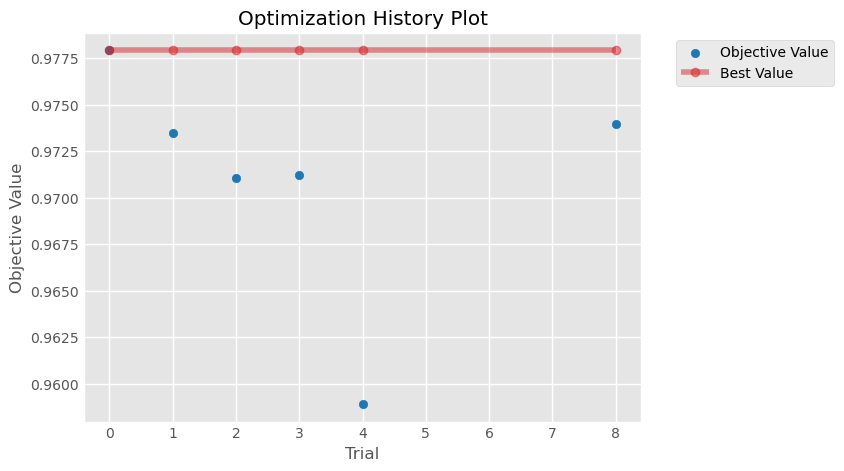

In [24]:
optuna.visualization.matplotlib.plot_optimization_history(study)

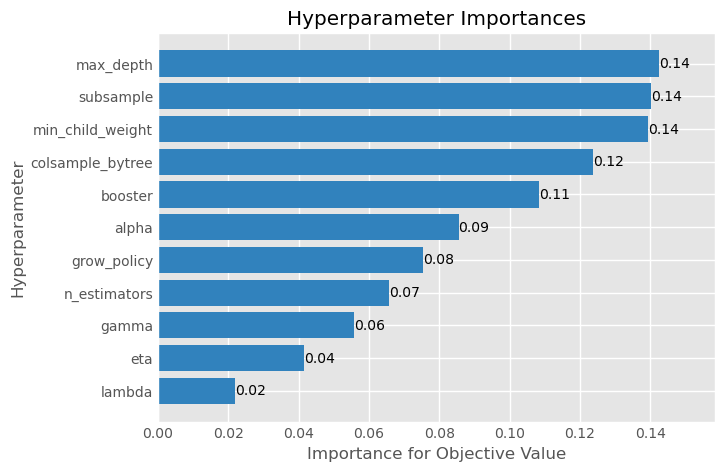

In [25]:
try:
    optuna.visualization.matplotlib.plot_param_importances(study)
except:
    print('Tuning only one hyper-parameter')

## Define and train model given the best hyperparameters

In [26]:
hyperparameters = best_trial_params

base_params = {"verbosity": 0,
               # "learning_rate": 0.003,
               "objective": "binary:logistic",
               # "tree_method": "hist",
               "n_jobs": -1}

hyperparameters.update(base_params)
print('Using these params:')
pprint(hyperparameters)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["error","auc"]
classifier = xgb.XGBClassifier(**hyperparameters)

Using these params:
{'alpha': 0.34131542003805226,
 'booster': 'gbtree',
 'colsample_bytree': 0.8695763223614645,
 'eta': 0.03276461912090576,
 'gamma': 0.013056567804844385,
 'grow_policy': 'depthwise',
 'lambda': 0.28496526548607803,
 'max_depth': 50,
 'min_child_weight': 3,
 'n_estimators': 200,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'subsample': 0.20584517186908002,
 'verbosity': 0}


In [27]:
classifier.fit(X_train, 
               y_train, 
               eval_set=eval_set, 
               eval_metric=eval_metric, 
               early_stopping_rounds=10, 
               verbose=0)

XGBClassifier(alpha=0.34131542003805226, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8695763223614645, early_stopping_rounds=None,
              enable_categorical=False, eta=0.03276461912090576,
              eval_metric=None, gamma=0.013056567804844385, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.28496526548607803,
              learning_rate=0.0327646174, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', ...)

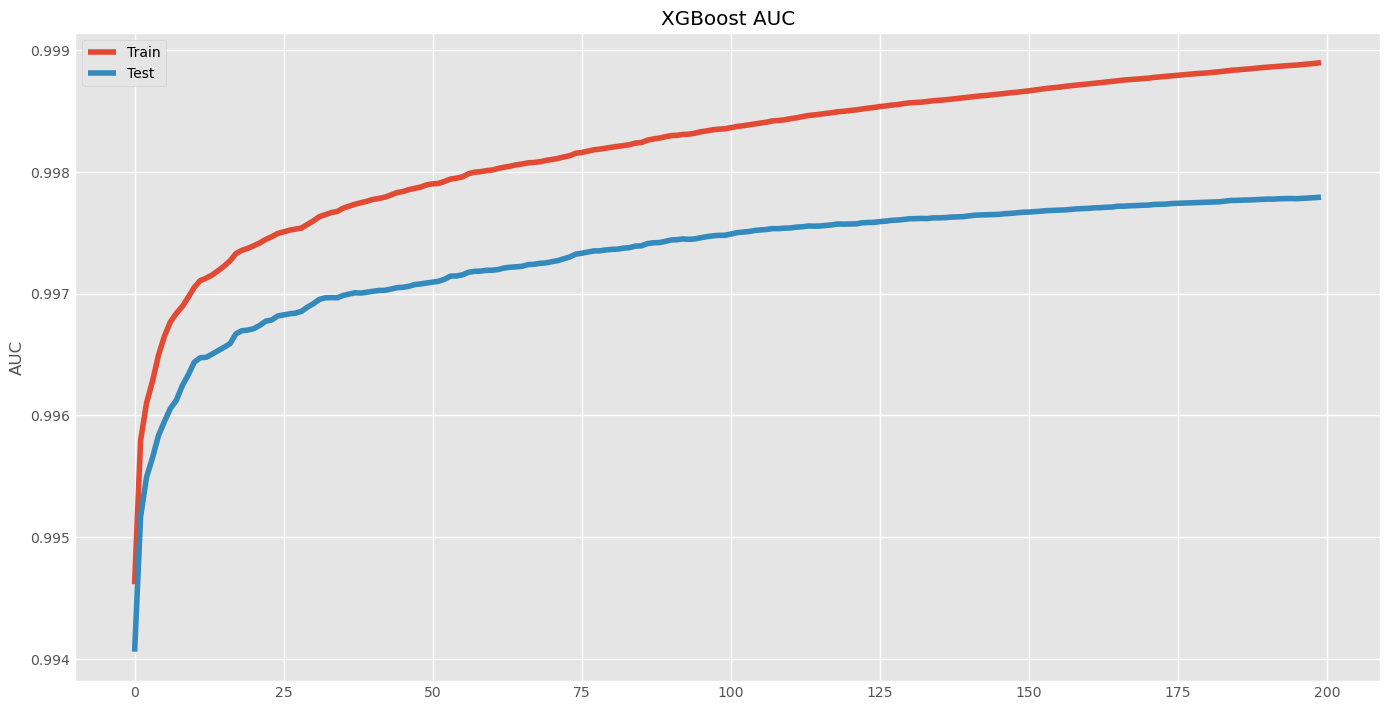

In [28]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

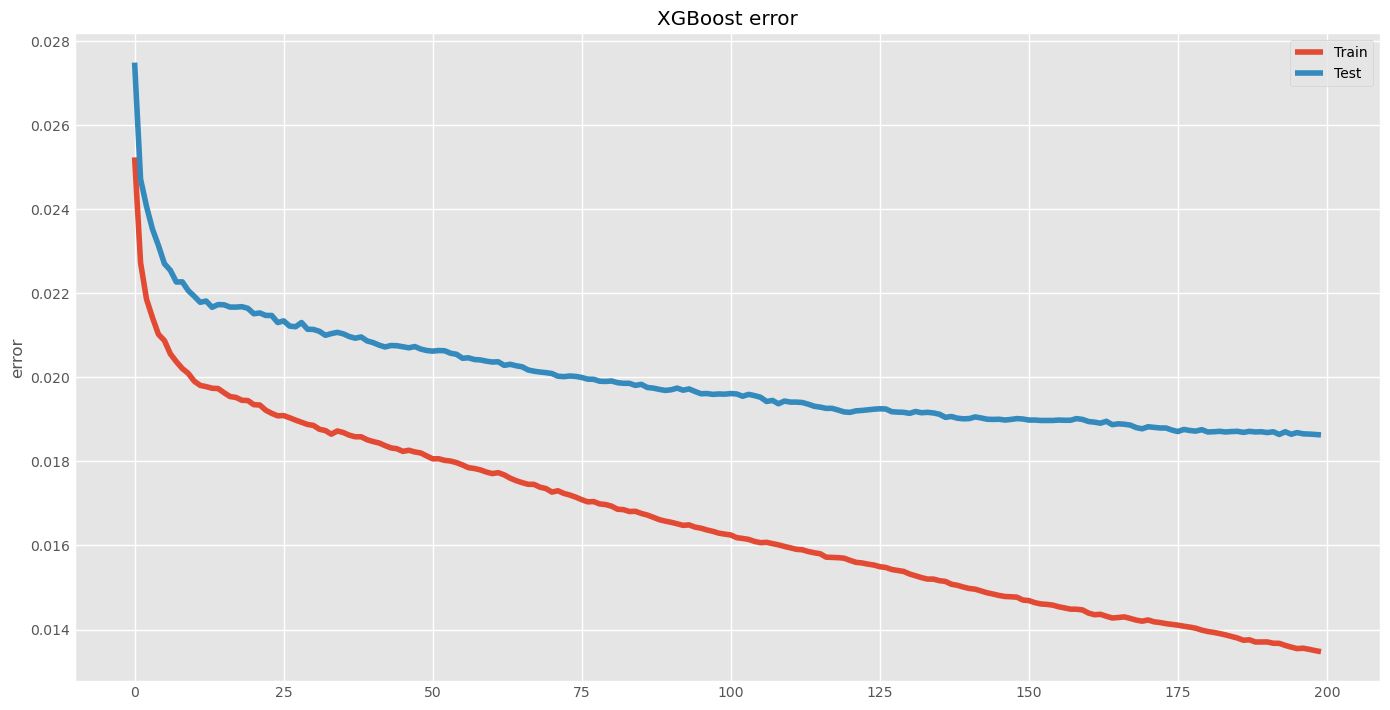

In [29]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [30]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.981

In [31]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [32]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [33]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
# From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp = confusion_matrix(y_test_int, test_predictions).ravel()
recall = (tp / (tp + fp))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('\nTest Matthews Correlation Coefficient (MCC)')
print('-------------------------------------------------------')
mcc = matthews_corrcoef(y_test_int, test_predictions)
print(mcc)
print('\nConfusion Matrix')
print('-------------------------------------------------------')
print('TP: {:9} FN: {:9}'.format(tp, fn))
print('FP: {:9} TN: {:9}'.format(fp, tn))

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    114595
           1       0.98      0.97      0.98     86805

    accuracy                           0.98    201400
   macro avg       0.98      0.98      0.98    201400
weighted avg       0.98      0.98      0.98    201400

Test Recall
-------------------------------------------------------
0.9819751854130154

Test Matthews Correlation Coefficient (MCC)
-------------------------------------------------------
0.9620039482456547

Confusion Matrix
-------------------------------------------------------
TP:     84606 FN:      2199
FP:      1553 TN:    113042


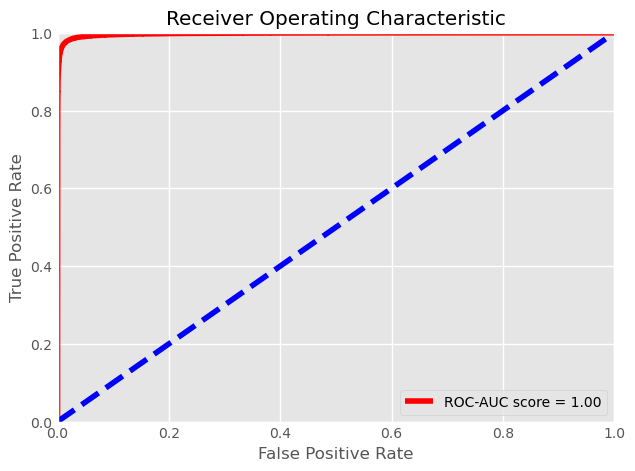

In [34]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## NDVI Over 10,000

In [35]:
ndviOver10Predictions = classifier.predict(ndviOverTenK)
withPrediction = ndviOverTenK.assign(water_prediction=ndviOver10Predictions)
print('Number of rows: {}'.format(len(ndviOverTenK.index)))
print('Number of water predictions: {}'.format(np.count_nonzero(ndviOver10Predictions == 1)))
print('Number of land predictions: {}'.format(np.count_nonzero(ndviOver10Predictions == 0)))
withPrediction

Number of rows: 2781
Number of water predictions: 2758
Number of land predictions: 23


,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,water_prediction
422689,11,-6,59,60,32,46,15,31536,-13000,-23333,1
80522,5,-17,18,89,-7,62,31,18333,-17555,31251,1
613549,-29,36,44,90,171,623,595,27321,-8907,-8858,1
963241,1,-83,252,103,-71,73,33,10243,24928,23200,1
472983,-3,2,48,64,86,140,87,15536,-9718,-9550,1
...,...,...,...,...,...,...,...,...,...,...,...
272725,-16,65,37,33,146,236,174,16530,-5681,-4560,1
107961,19,-12,103,98,69,13,38,21251,12144,-19230,1
359280,-4,10,74,111,125,99,18,23333,-8165,-2857,1
630119,8,-24,156,89,9,17,37,20000,-6965,18613,1


In [36]:
withPrediction[withPrediction['water_prediction'] == 0]

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,water_prediction
144736,-100,276,986,1412,2505,2416,1954,21363,-7949,-7524,0
217247,-100,1717,-100,-100,1702,1661,608,11236,165,4769,0
792277,-100,1013,-100,-100,2021,2264,1032,12190,-3817,-92,0
806550,-65,1357,785,868,1762,1335,932,11006,81,1856,0
370458,-100,1463,-1,173,1442,765,269,11467,3132,6893,0
154546,-100,3308,123,430,2735,1290,428,10623,4388,7708,0
822373,-100,2731,-100,-100,2300,1164,348,10760,4023,7739,0
119132,-68,3182,-100,75,3337,2049,996,10436,2165,5232,0
965897,-100,1353,1632,2096,2309,1995,805,11596,-1917,2539,0
632559,-100,563,-100,-100,2300,1164,348,14319,-3480,2360,0


## Permutation importance

In [37]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

Saved to: /explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/mw_Golden_0.981_200_xgboost_2023_02_16_11_56_permutation_importance.png


Text(0.5, 0, 'Permutation Importance')

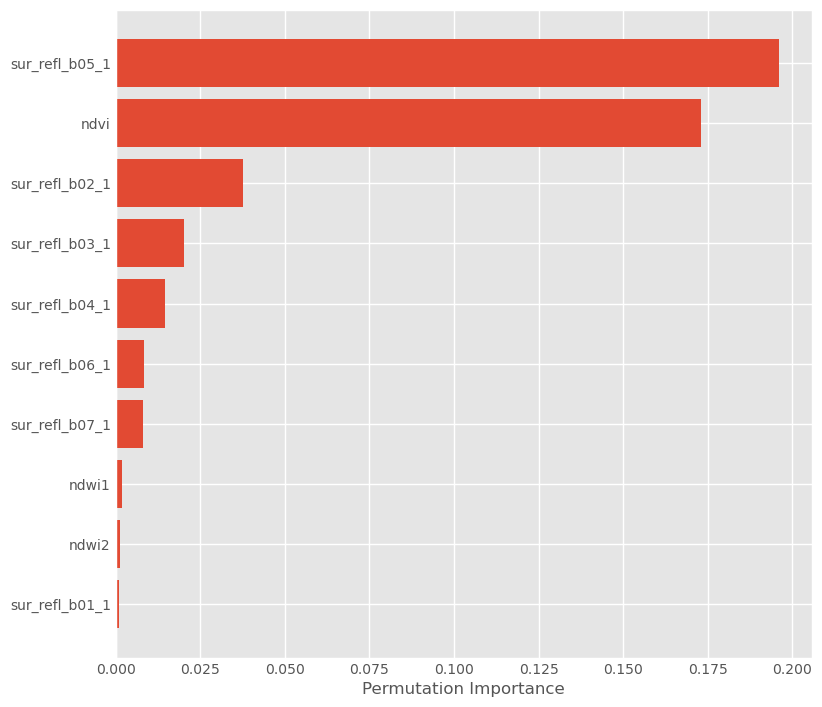

In [38]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)
print('Saved to: {}'.format(png_save_path))
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
# plt.savefig(png_save_path)

In [39]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [40]:
model_save_path = 'mw_{}_{}_{}_{}_4.0.0_tuned_{}.sav'.format(TILE,
                                                      score,
                                                      hyperparameters['n_estimators'],
                                                      MODEL,
                                                      'gpu' if GPU else 'cpu',
                                                      datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.981_200_xgboost_4.0.0_tuned_gpu.sav
XGBClassifier(alpha=0.34131542003805226, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8695763223614645, early_stopping_rounds=None,
              enable_categorical=False, eta=0.03276461912090576,
              eval_metric=None, gamma=0.013056567804844385, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.28496526548607803,
              learning_rate=0.0327646174, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', ...)


['/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.981_200_xgboost_4.0.0_tuned_gpu.sav']

# Testing: Raster testing

In [41]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [42]:
TILE = 'h11v10'
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [43]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006201.h11v10*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf
Julian day: 201
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [44]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [45]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [46]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size


In [47]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [48]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 11min 3s, sys: 2.87 s, total: 11min 6s
Wall time: 18.6 s


## Inputreshapet raster: description and histogram

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,1140.560665,1527.279099,-28672.0,227.0,463.0,1397.0,11069.0
sur_refl_b02_1,23040000.0,2658.499274,1132.979425,-28672.0,2082.0,2533.0,2899.0,10802.0
sur_refl_b03_1,23040000.0,829.334512,1460.147104,-28672.0,152.0,242.0,685.0,9552.0
sur_refl_b04_1,23040000.0,1086.797176,1447.336811,-28672.0,356.0,496.0,1055.0,10207.0
sur_refl_b05_1,23040000.0,2919.611193,1008.000270,-28672.0,2444.0,2757.0,3154.0,8725.0
sur_refl_b06_1,23040000.0,2214.756003,1198.891539,-28672.0,1332.0,1835.0,2798.0,7891.0
sur_refl_b07_1,23040000.0,1316.849571,1626.572310,-28672.0,431.0,873.0,2086.0,8951.0
ndvi,23040000.0,5099.909421,3622.130717,-32758.0,1772.0,6266.0,8435.0,32762.0
ndwi1,23040000.0,1035.434987,2495.314006,-32758.0,-812.0,825.0,3330.0,32762.0
ndwi2,23040000.0,3787.883306,3553.893702,-32758.0,542.0,4209.0,7222.0,32762.0


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [50]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [51]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


In [52]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [54]:
maskedResult = np.where(qa_mask == 0, reshp, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Predicted Raster

In [56]:
import math

In [57]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

### Count num of occurences for each class with the masked predicted result

In [58]:
countNoData = np.count_nonzero(maskedResult == 255)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5671456
 Land occurance: 16819019
 Water occurances: 549525


### Count num of occurences for each class with the water mask

In [59]:
countNoDataT = np.count_nonzero(waterMasked == 255)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5671456
 Land occurance: 17043705
 Water occurances: 324839


### Model metrics on raster data

In [60]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

Metrics of Accuracy for Raster Test Data
True Positives:  303306
True Negatives:  16797486
False Positives: 246219
False Negatives: 21533
Total "good" data: 17368544
Accuracy*: 0.9845840848835689
Precision: 0.5519421318411355
Recall: 0.9337117772188684
f1: 0.6937751325534903
MCC: 0.711480439651289


## Output predicted raster to GeoTiff

In [61]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_xgboost.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/waterMask_2006_qa_201.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_probabilities_xgboost.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, -1111950.519667, 0.0, -231.65635826374995)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


## Folium viewing

In [62]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [63]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [64]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)


cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568


In [65]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [66]:
from folium import plugins


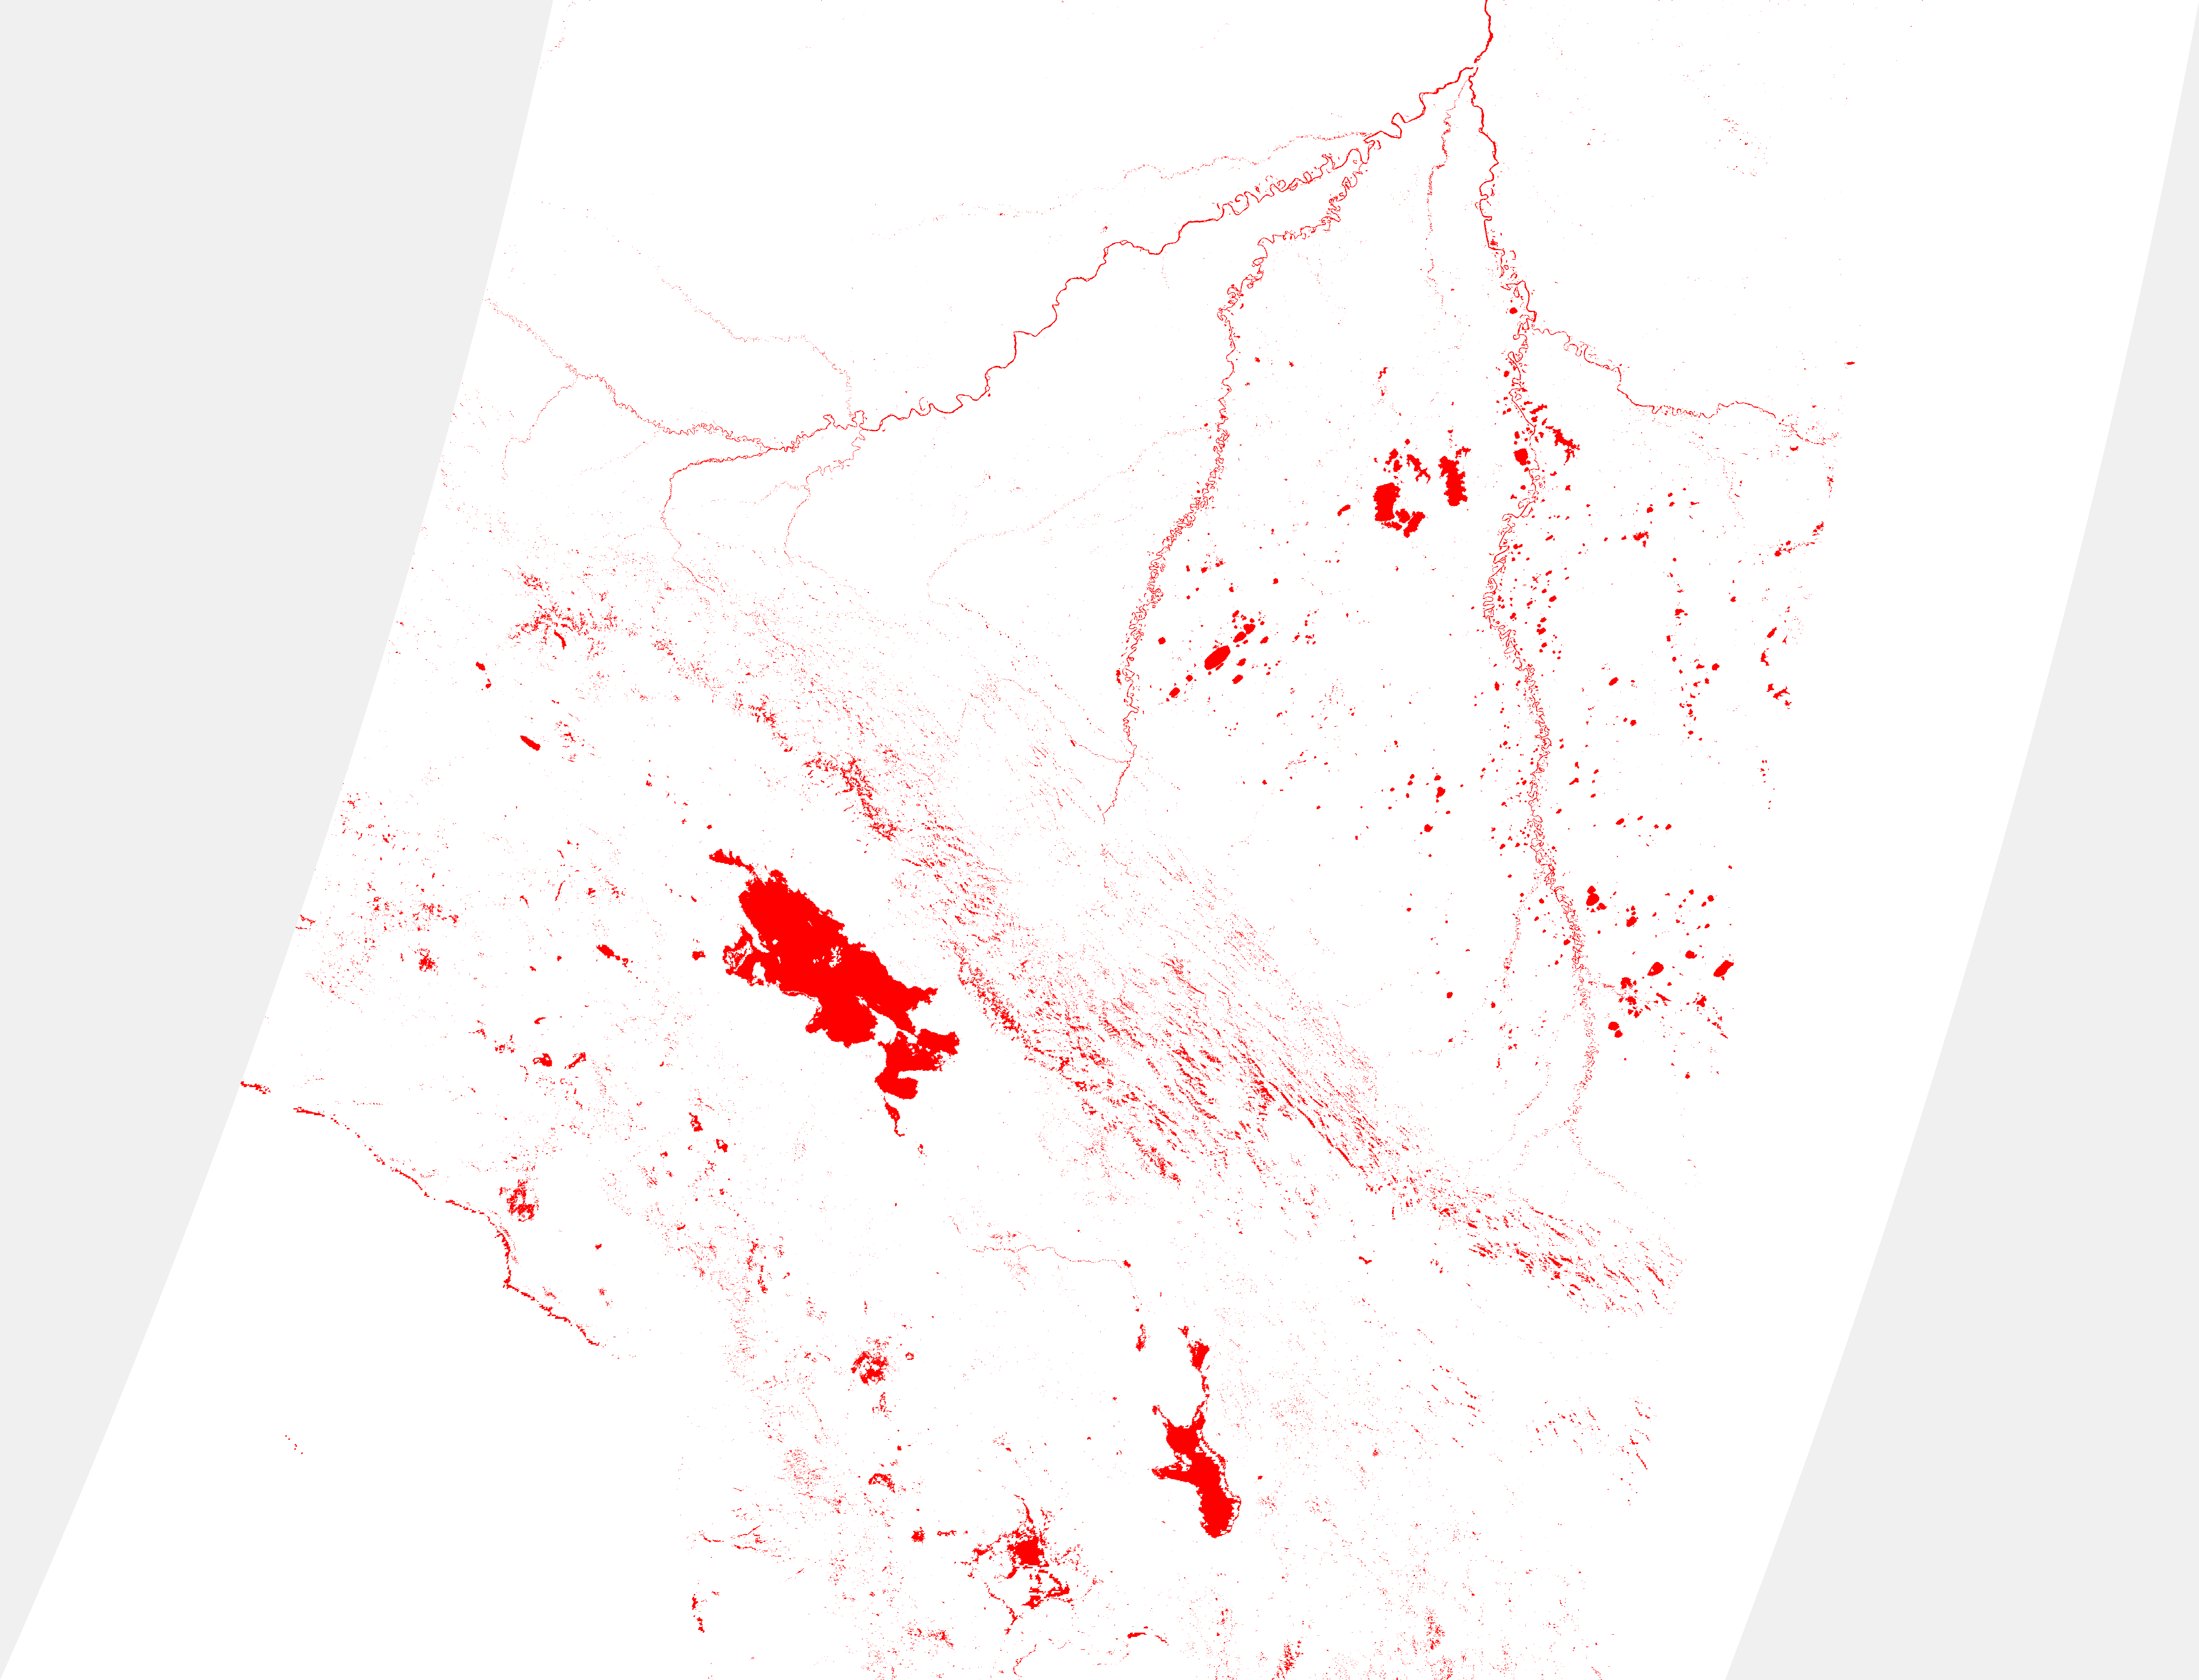
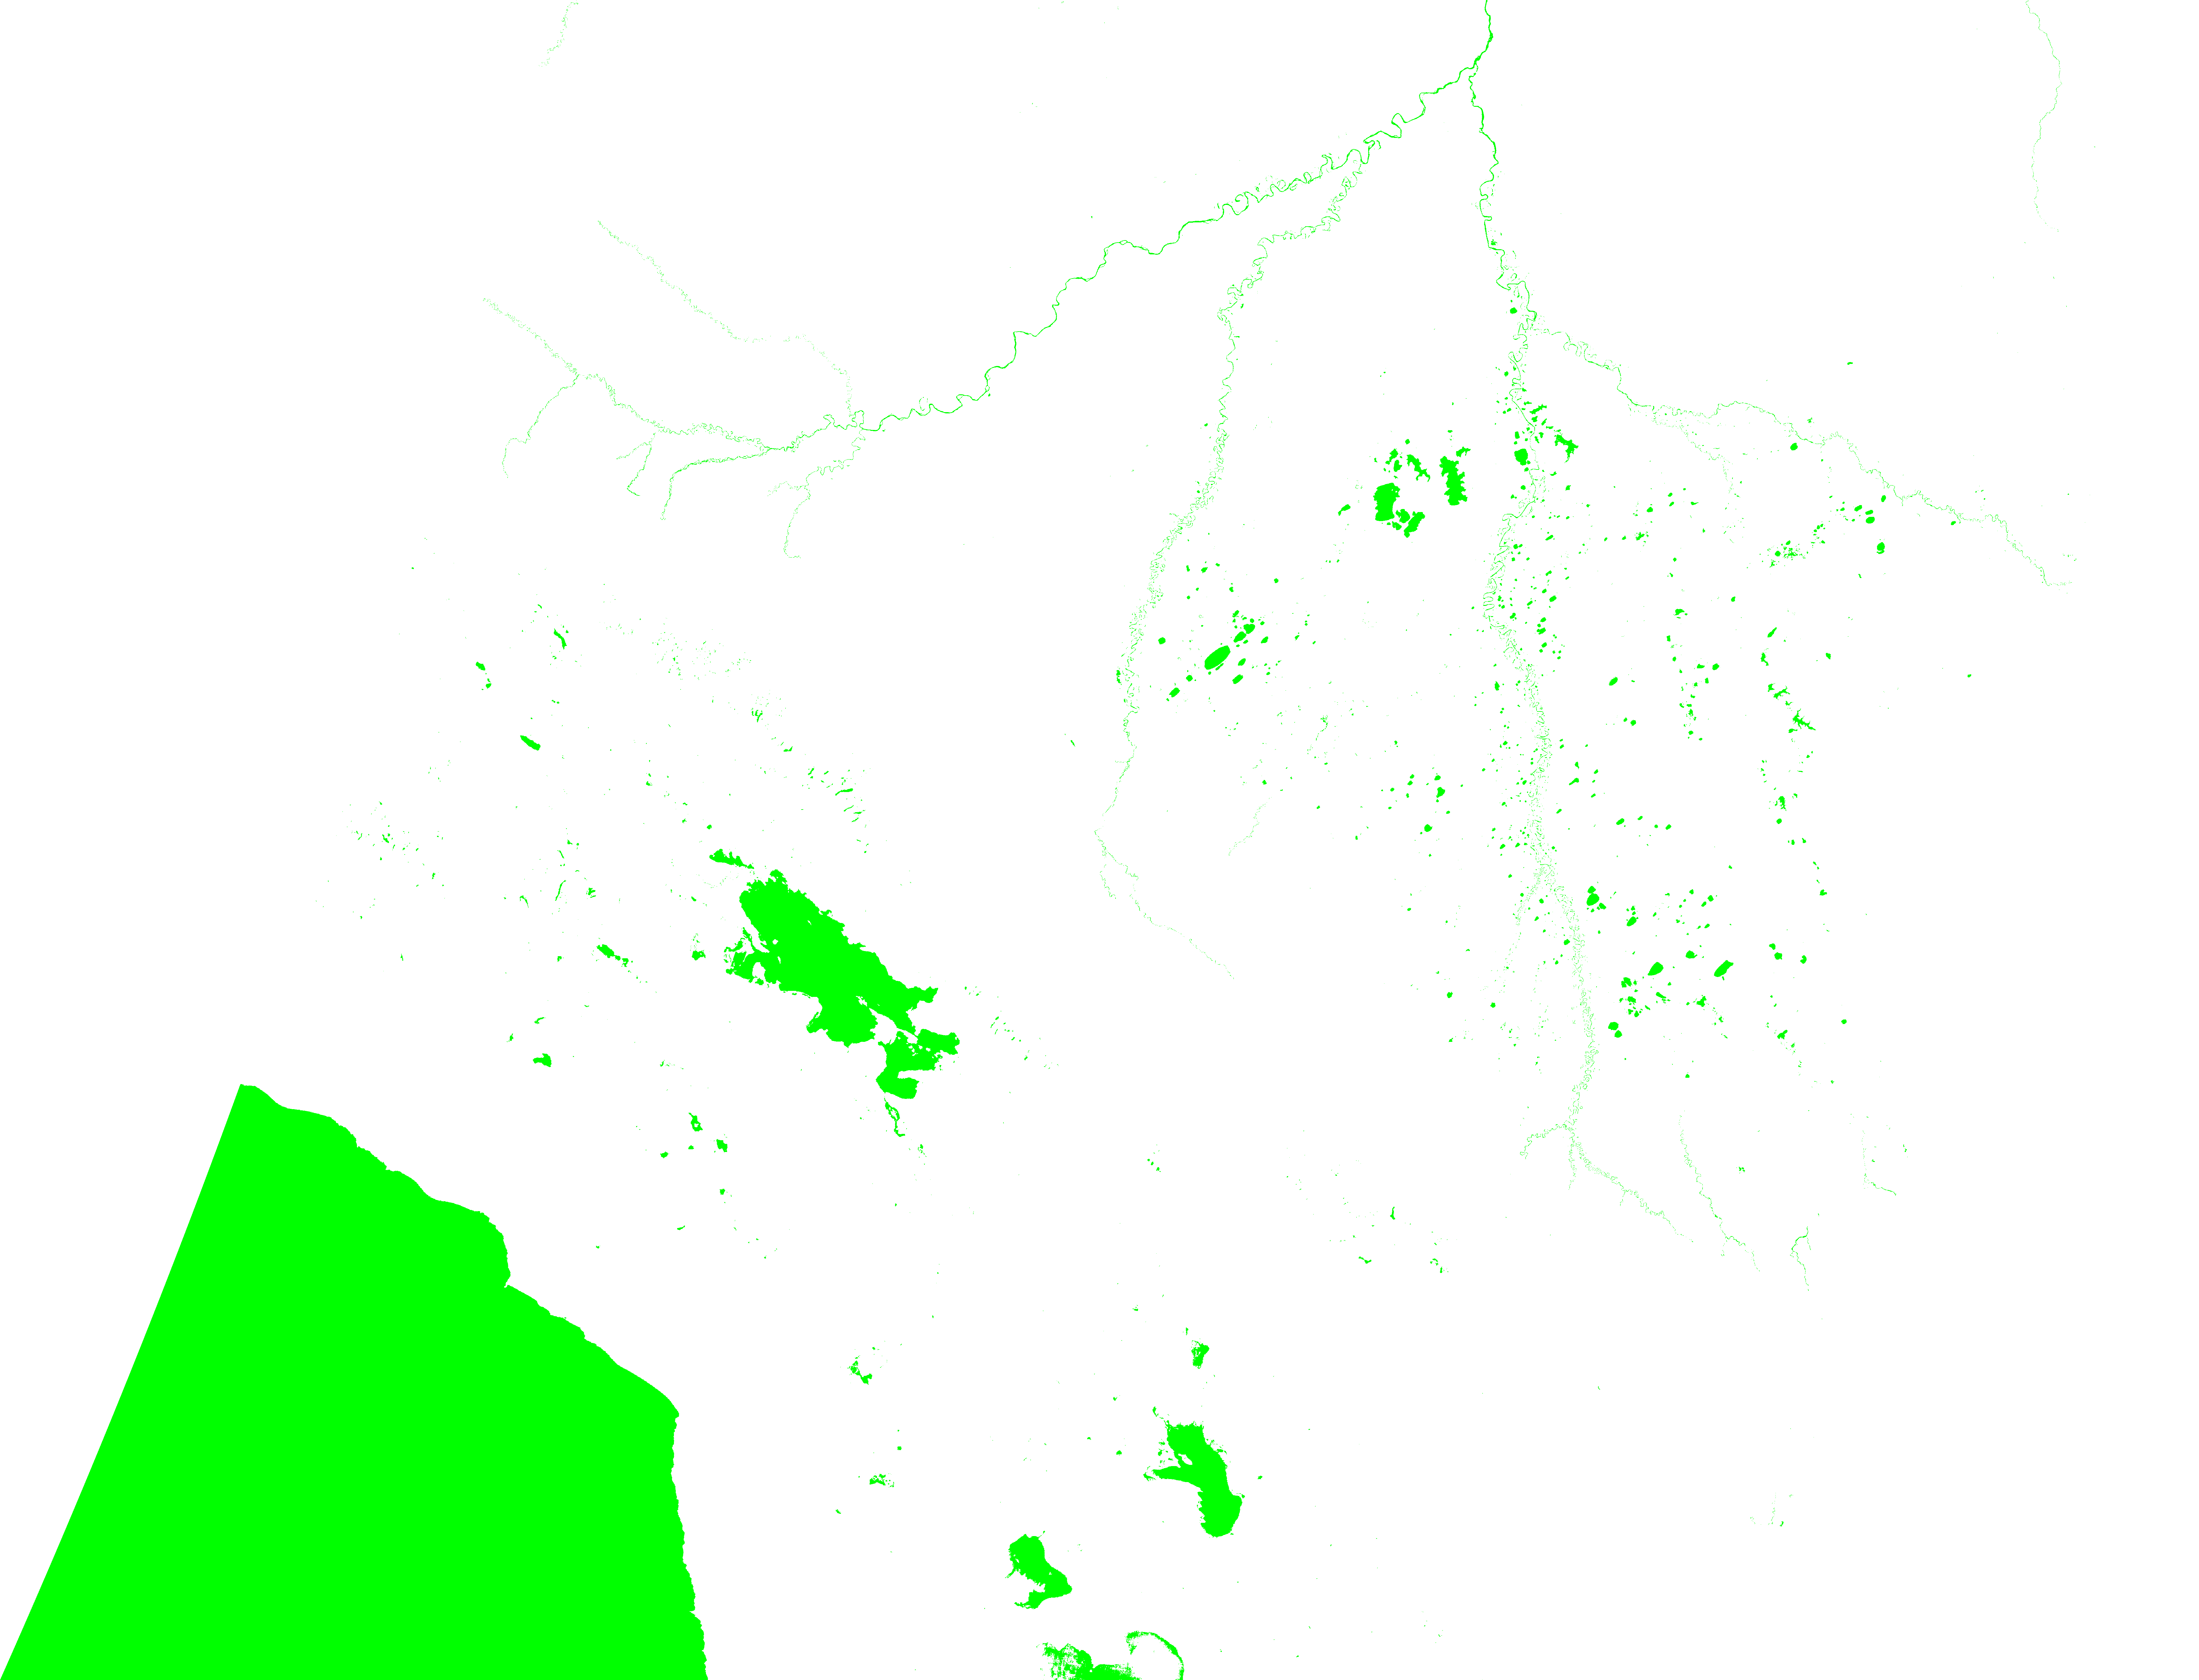
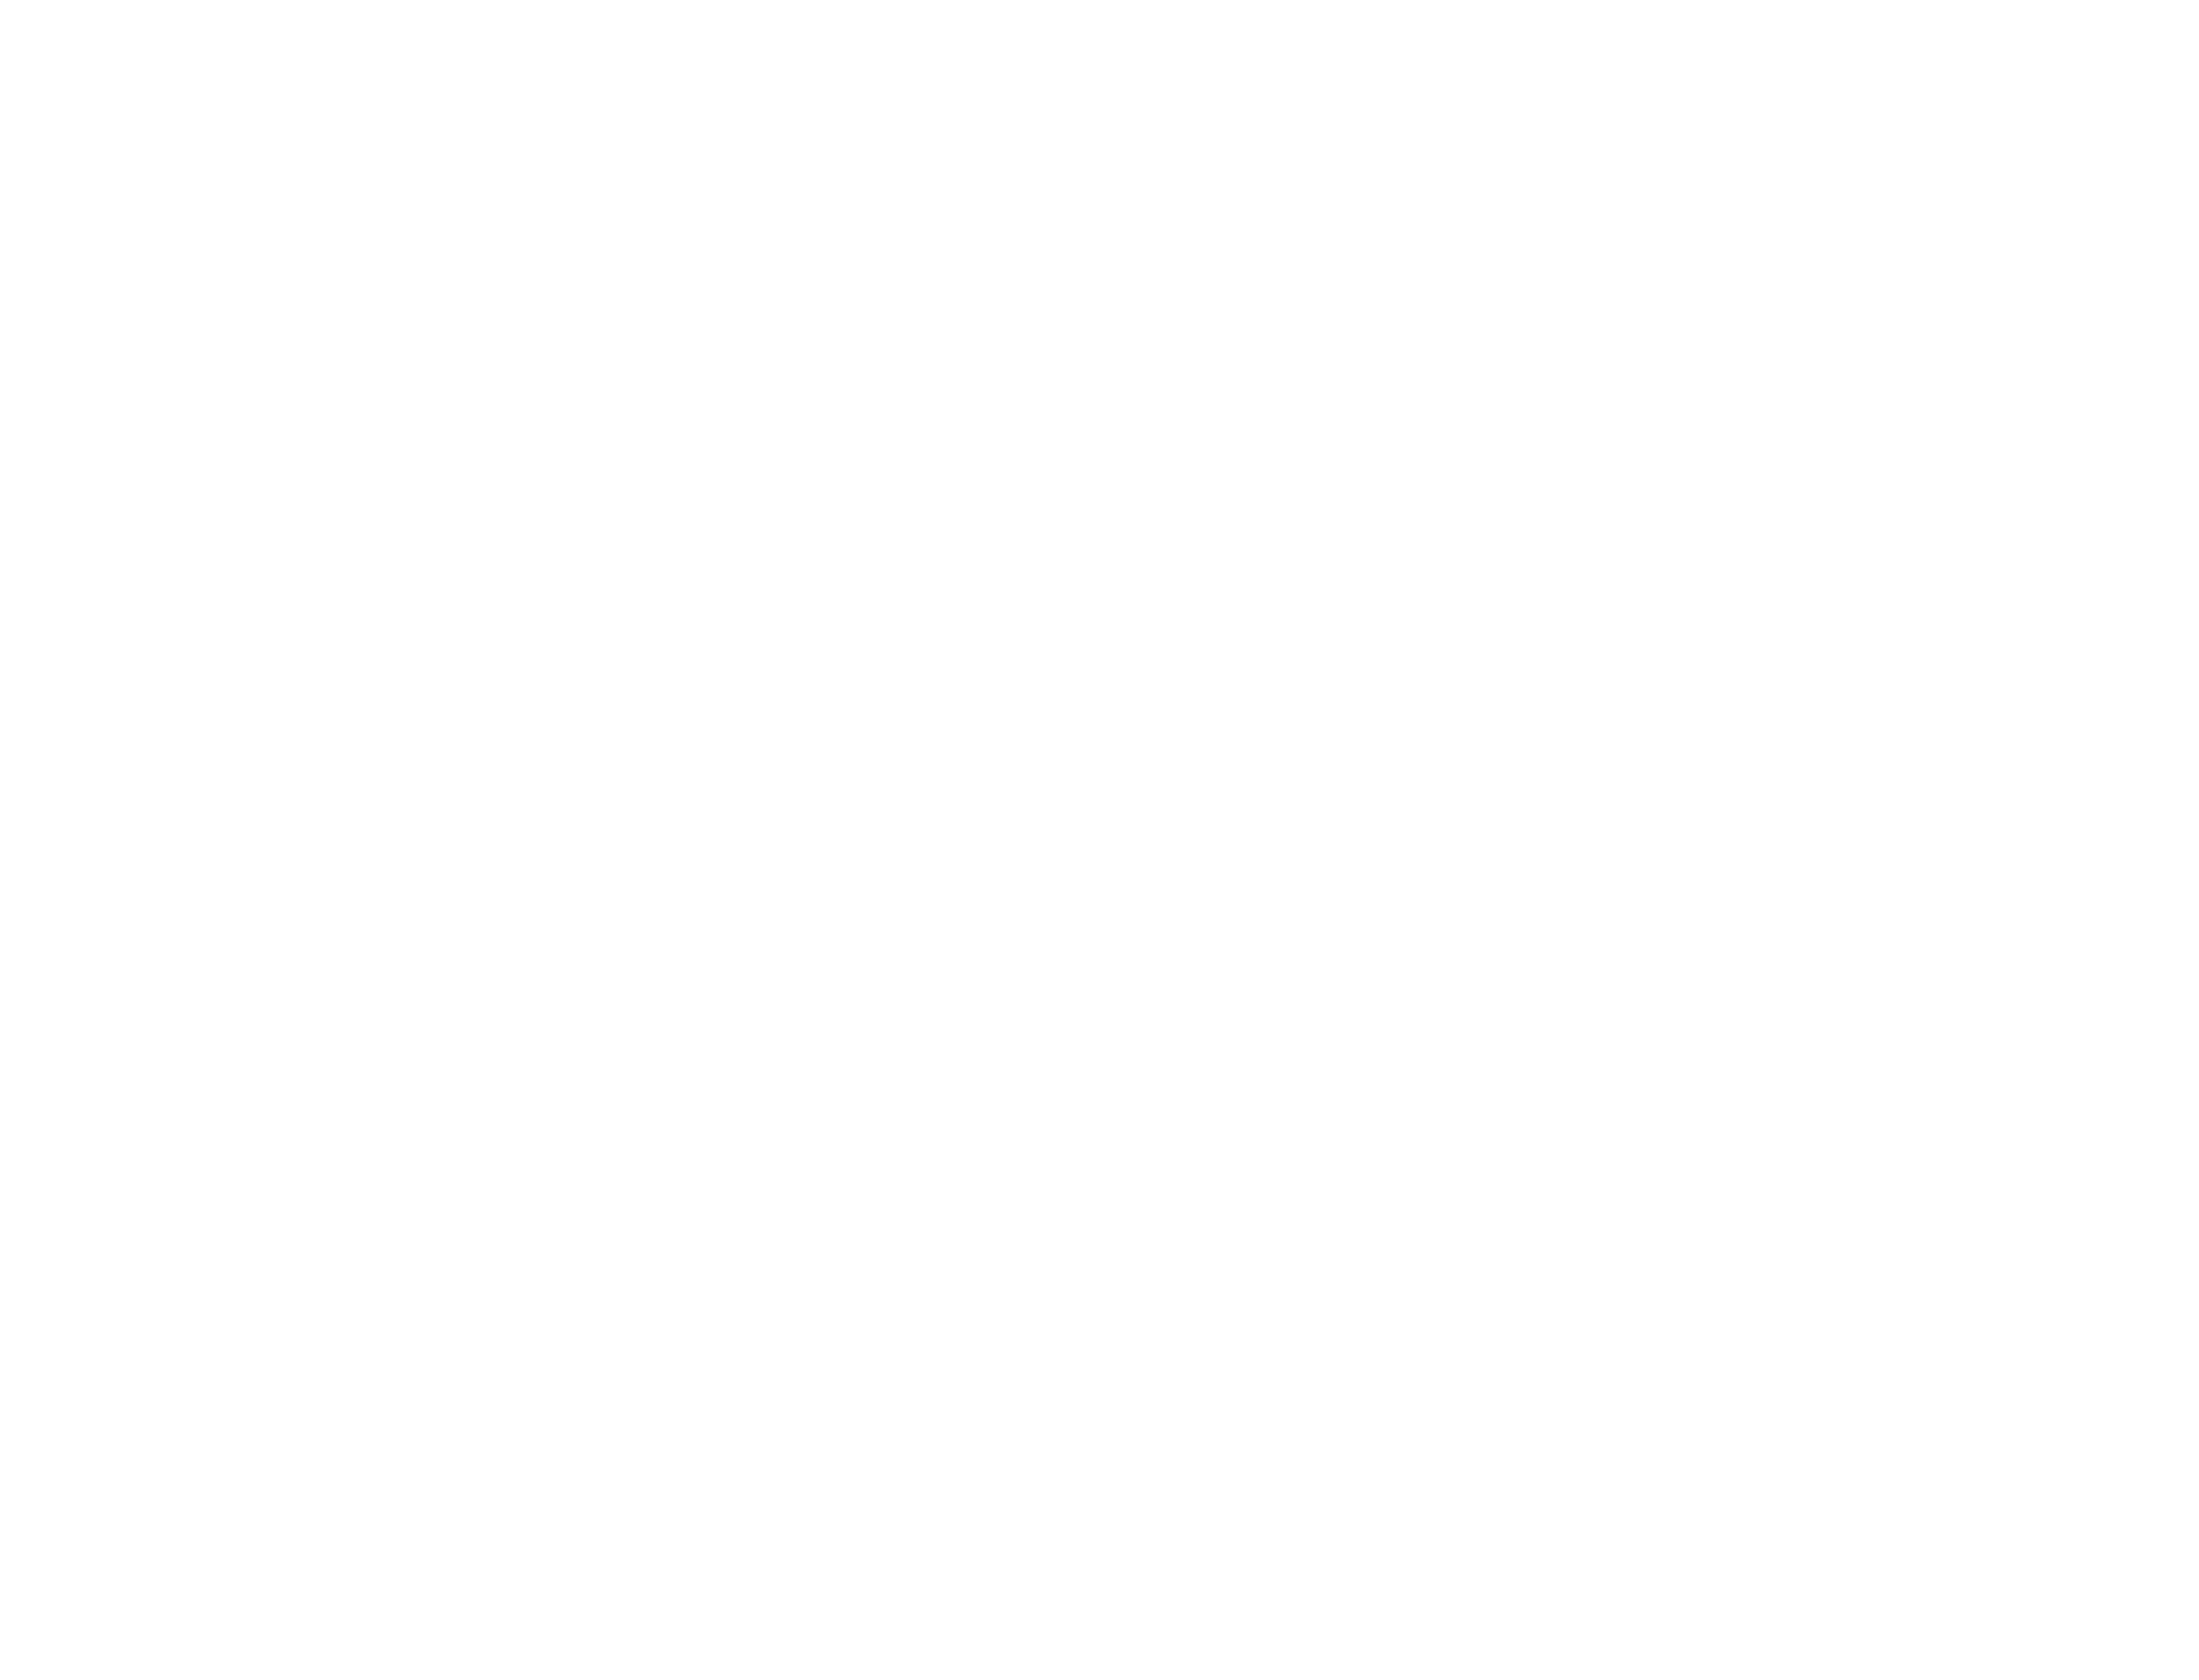

In [67]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())